# Librerias

In [7]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

# Lectura de datos

In [8]:
# Cargar el archivo .nc utilizando xarray
data_boyaca = xr.open_dataset('../data/data_Boyaca.nc')

# Leer el shapefile con los municipios de Boyacá
shape_boyaca_municipios = gpd.read_file('../shapes/shape_boyaca_municipios.shp')

# Seleccionar la variable de precipitación
precipitation = data_boyaca['precip']

# Formatos archivos

In [9]:
# Verificar los nombres de las variables disponibles
print(data_boyaca)

# cantidad de datos que tiene el archivo .nc
print('cantidad de datos: ',data_boyaca['precip'].size)

# Muestra el formato
print('shapefile : ',shape_boyaca_municipios)

<xarray.Dataset>
Dimensions:    (time: 15491, latitude: 48, longitude: 54)
Coordinates:
  * latitude   (latitude) float32 4.675 4.725 4.775 4.825 ... 6.925 6.975 7.025
  * longitude  (longitude) float32 -74.68 -74.63 -74.58 ... -72.13 -72.08 -72.03
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2023-05-31
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    

# Mapa de calor del promedio de la precipitación mensual para cada año

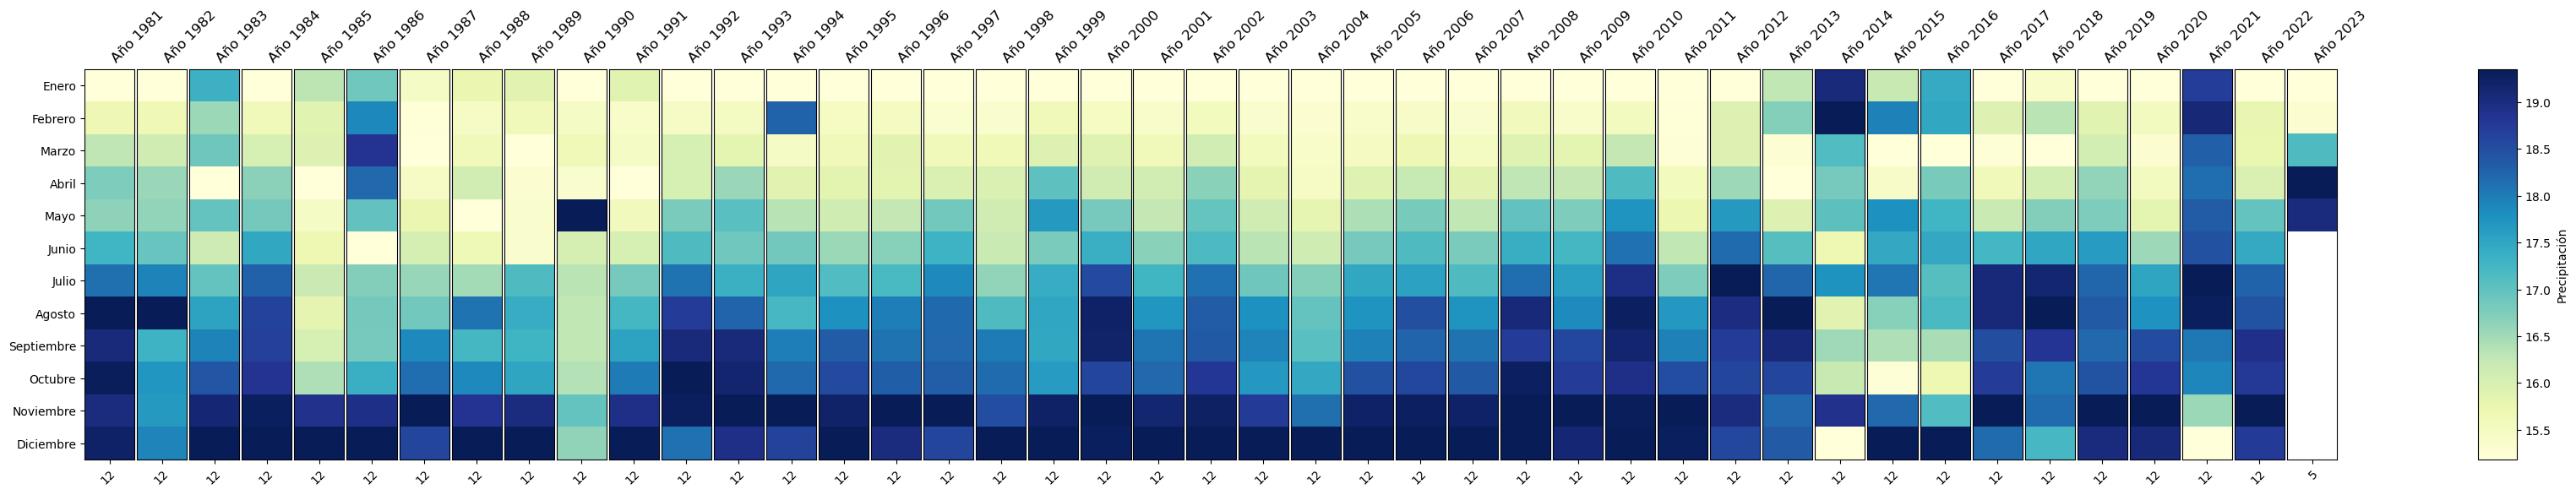

In [10]:
# Convertir el índice de tiempo a una serie de pandas
time_series = pd.Series(precipitation.time.values)

# Obtener los años únicos
años_disponibles = time_series.dt.year.unique()

# Calcular el número de mapas de calor
num_mapas = len(años_disponibles)

# Ajustar el espacio entre las subtramas y el tamaño de la figura
fig, axs = plt.subplots(1, num_mapas, figsize=(num_mapas, 6), sharey=True)

plt.subplots_adjust(wspace=0.05)

# Iterar sobre cada año y generar el mapa de calor en el gráfico correspondiente
for i, año in enumerate(años_disponibles):
    # Seleccionar los datos de precipitación para el año actual
    precipitacion_anual = precipitation.sel(time=str(año))
    
    # Calcular la precipitación mensual promedio
    precipitacion_mensual = precipitacion_anual.groupby('time.month').mean(dim='time')
    
    # Tratamiento de datos atípicos por mes utilizando el rango intercuartil (IQR)
    Q1 = precipitacion_mensual.quantile(0.25, dim='month')
    Q3 = precipitacion_mensual.quantile(0.75, dim='month')
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Reemplazar los valores atípicos por el promedio del mes correspondiente
    precipitacion_mensual = precipitacion_mensual.where((precipitacion_mensual >= lower_bound) & (precipitacion_mensual <= upper_bound), precipitacion_mensual.mean(dim='month'))
    
    # Crear un dataframe de Pandas a partir de los datos
    df = precipitacion_mensual.to_dataframe()

    # número de meses en el año
    num_meses = len(df.index.get_level_values(0).unique())
    
    # Obtener los últimos 12 meses de datos
    df = df.iloc[-num_meses:]
    
    # Reorganizar los datos en un formato adecuado para el mapa de calor
    df_heatmap = df.unstack(level=0)['precip']
    
    # Obtener el gráfico correspondiente
    ax = axs[i]
    
    # Crear el mapa de calor utilizando Matplotlib
    heatmap = ax.imshow(df_heatmap, cmap='YlGnBu', aspect='auto')
    
    # Personalizar el mapa de calor
    ax.set_xticks(np.arange(len(df_heatmap.columns)))
    ax.set_yticks(np.arange(12))
    
    # Establecer las etiquetas del eje y en el primer gráfico para siempre mostrar 12 meses
    if i == 0:
        month_labels = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
        ax.set_yticks(np.arange(len(month_labels)))  
        ax.set_yticklabels(month_labels)  
    else:
        ax.get_yaxis().set_visible(False)

    
    # Establecer las etiquetas del eje x
    ax.set_xticklabels(df_heatmap.columns, rotation=45, ha='right', rotation_mode='anchor')
    
    # Agregar un título con el año actual
    ax.set_title('Año {}'.format(año), rotation=45, ha='left')

    # Ajustar los límites del eje y para que las etiquetas del eje y se muestren completamente en el primer gráfico
    if i == 0:
        ax.set_ylim(len(month_labels)-0.5, -0.5)

# Agregar una única barra de color
cbar = fig.colorbar(heatmap, ax=axs, aspect=10)
cbar.set_label('Precipitación')


# Mostrar el gráfico
plt.show()


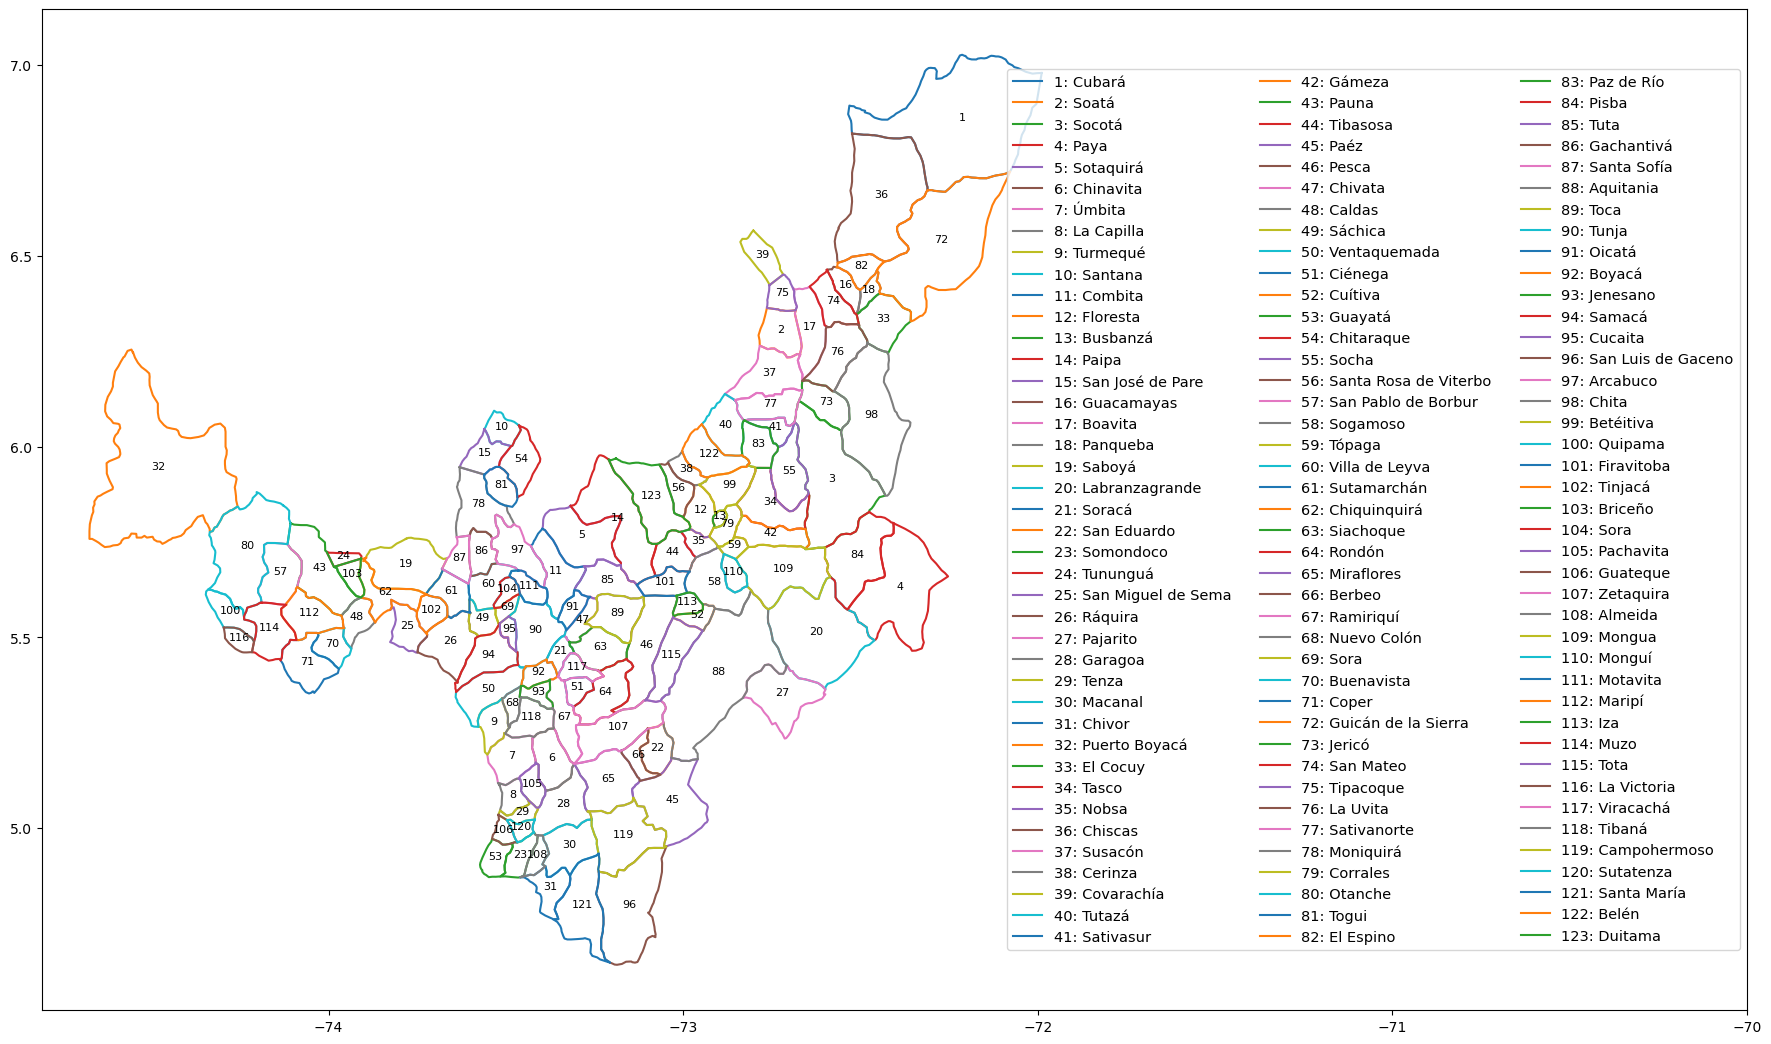

In [11]:
# Grafico con los poligonos ordenados
# Crear una figura y un eje
fig, ax = plt.subplots()
fig.set_size_inches(22, 13)

for i, polygon in enumerate(shape_boyaca_municipios.geometry):
    x, y = polygon.exterior.xy
    ax.plot(x, y)
    centroid = polygon.centroid
    ax.annotate(str(i+1), (centroid.x, centroid.y), textcoords="offset points", xytext=(0,0), ha='center', fontsize=8)

# Etiquetas de leyenda
etiquetas_leyenda = [f"{i+1}: {shape_boyaca_municipios.iloc[i]['municipio']}" for i in range(len(shape_boyaca_municipios))]

# Agregar la leyenda al gráfico
ax.legend(labels=etiquetas_leyenda, fontsize=10.5, ncol=3, loc='center right')
# Agrandar el eje x para que quepa la leyenda
ax.set_xlim(right=-70)

# Mostrar el gráfico
plt.show()


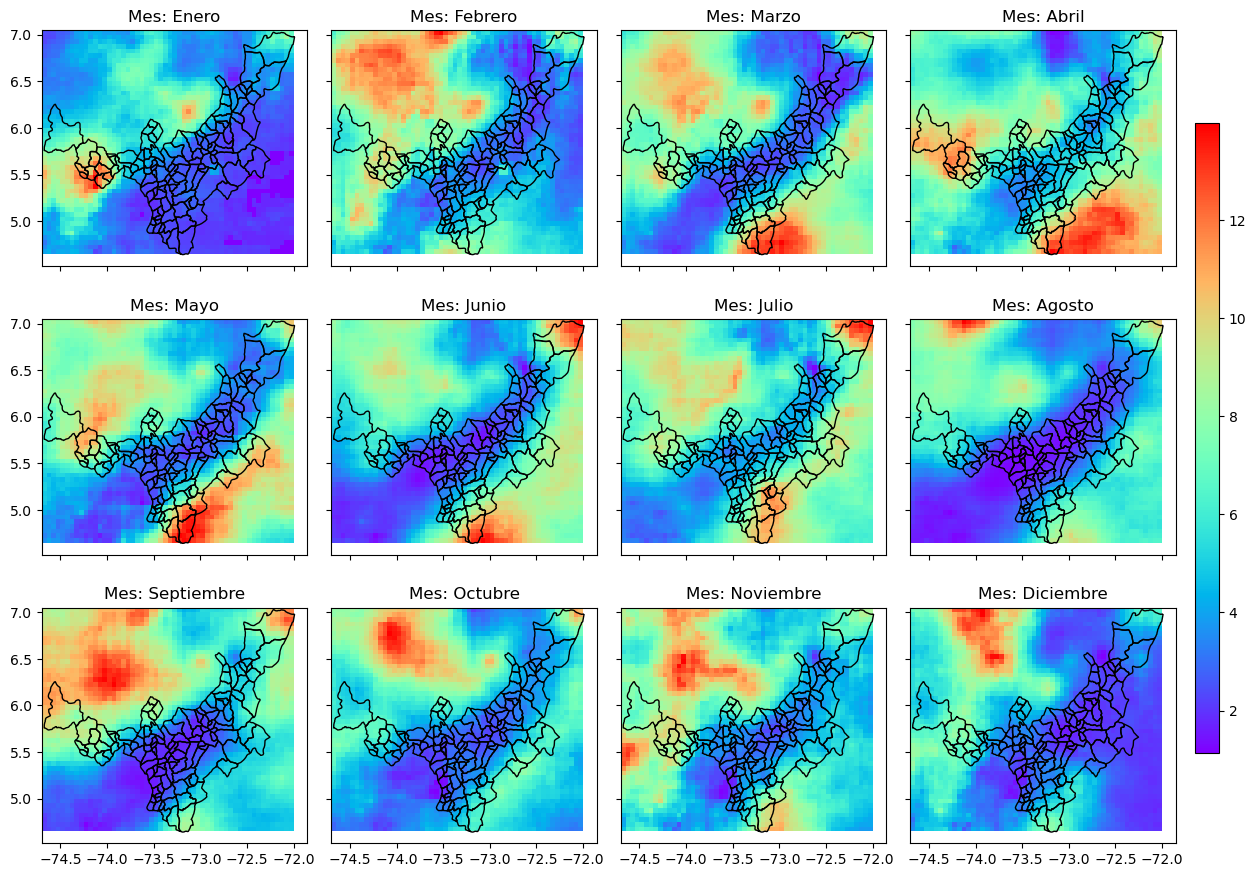

In [12]:
import calendar
import locale

def plot_precipitation_data(precipitation, shape_boyaca_municipios, year):
    # Configurar el idioma local en español
    locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

    # Seleccionar un año específico
    pr_year = precipitation.sel(time=str(year))

    # Crear la cuadrícula de subtramas
    fig, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)

    # Iterar sobre los meses
    for month, ax in zip(range(1, 13), axes.flat):
        # Seleccionar el mes específico
        pr_month = pr_year.sel(time=slice(f'{year}-{month:02}-01', f'{year}-{month:02}-{calendar.monthrange(year, month)[1]}'))

        # Obtener el nombre del mes en español
        month_name = calendar.month_name[month].capitalize()

        # Calcular el promedio de precipitación para cada punto
        precip_avg = pr_month.mean(dim='time')

        # Convertir a valores normales para el trazado
        x = precip_avg.longitude.values
        y = precip_avg.latitude.values
        xx, yy = np.meshgrid(x, y)

        # Plot del mapa de calor en la subtrama actual
        im = ax.pcolormesh(xx, yy, precip_avg.values, shading='auto', cmap='rainbow')
        shape_boyaca_municipios.plot(ax=ax, color='none', edgecolor='k')
        ax.set_title(f'Mes: {month_name}')

    # Ajustar los espacios entre las subtramas
    plt.tight_layout()

    # Agregar una barra de color común para todos los mapas de calor
    cax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax)

    # Mostrar la figura
    plt.show()

# Uso del código
year = 2010
plot_precipitation_data(precipitation, shape_boyaca_municipios, year)


1. Gráfico de Análisis de Tendencias:
   - En este gráfico, se muestra la precipitación promedio a lo largo del tiempo en el área de Boyacá.
   - La línea azul representa el promedio de la precipitación en función del tiempo.
   - La línea roja discontinua indica la tendencia de la precipitación a lo largo del tiempo, calculada mediante una regresión lineal.
   - Si la línea roja tiene una pendiente positiva, indica un aumento en la precipitación a medida que pasa el tiempo, mientras que una pendiente negativa indica una disminución en la precipitación.

2. Gráfico de Anomalías y Variabilidad Interanual:
   - Este gráfico muestra las anomalías de precipitación y la variabilidad interanual en el área de Boyacá.
   - Las anomalías de precipitación se calculan restando el promedio anual de la precipitación de cada año individual.
   - El gráfico muestra la media de estas anomalías a lo largo del tiempo.
   - Los valores positivos indican que la precipitación en un año determinado fue superior al promedio anual, mientras que los valores negativos indican una precipitación por debajo del promedio.

3. Gráfico de Estacionalidad de la Precipitación:
   - Este gráfico representa la estacionalidad de la precipitación en el área de Boyacá.
   - Se calcula el promedio mensual de la precipitación.
   - Cada punto en el gráfico de dispersión representa el promedio mensual de la precipitación en un determinado mes a lo largo del tiempo.
   - Este gráfico nos permite identificar patrones estacionales en la precipitación. Por ejemplo, si hay una concentración de puntos más altos en ciertos meses, indica una estacionalidad marcada en esos meses.




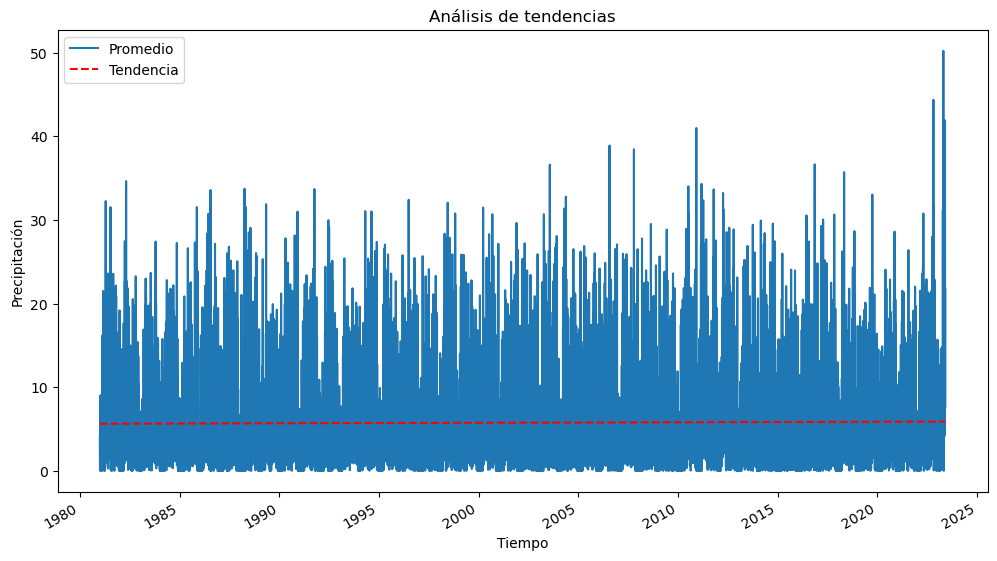

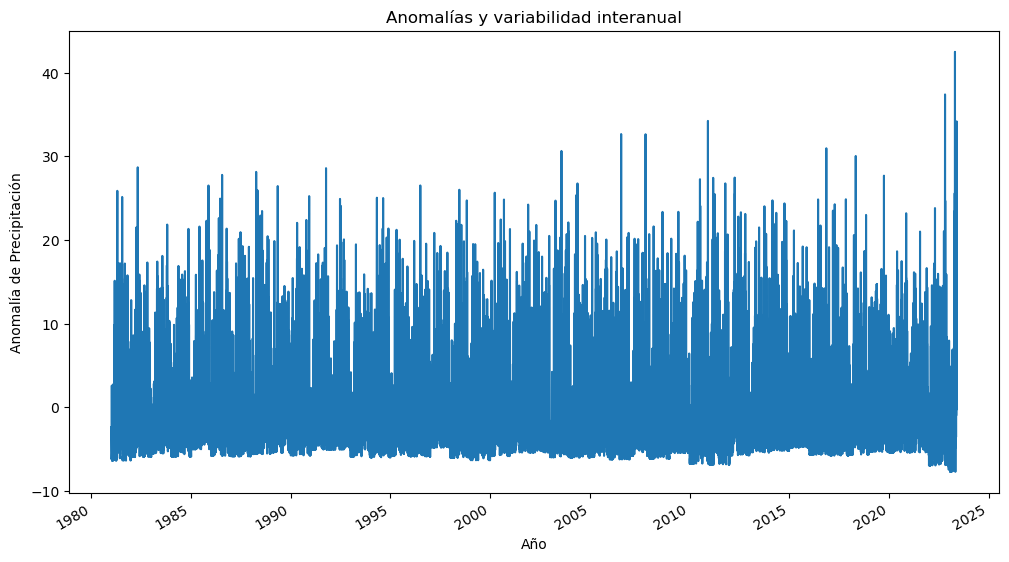

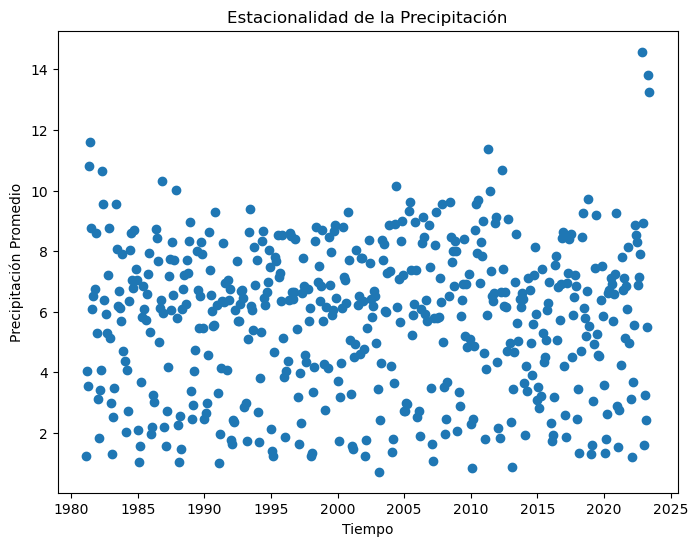

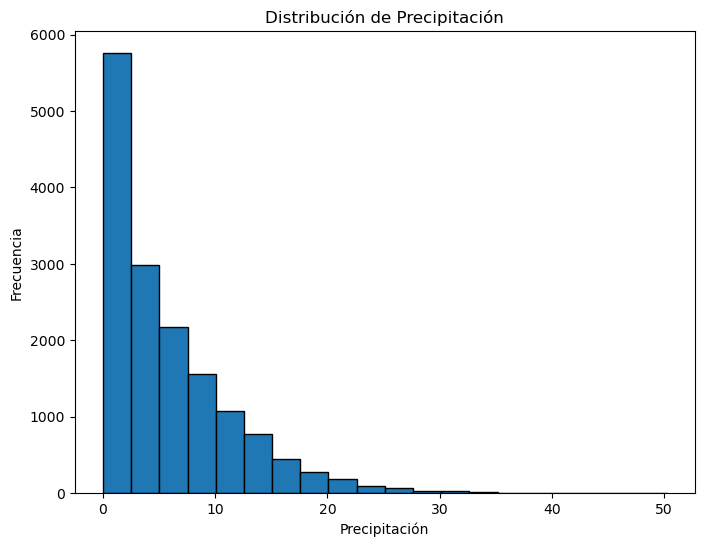

In [13]:
# Convertir las fechas a tipo np.datetime64
data_boyaca['time'] = data_boyaca.time.astype('datetime64[ns]')

# Análisis de tendencias
trends = np.polyfit(data_boyaca.time.values.astype(float), data_boyaca.precip.mean(dim=('latitude', 'longitude')).values, deg=1)
trend_line = np.polyval(trends, data_boyaca.time.values.astype(float))

# Anomalías y variabilidad interanual
annual_mean = data_boyaca.precip.groupby('time.year').mean(dim='time')
anomalies = data_boyaca.precip.groupby('time.year') - annual_mean
anomalies_mean = anomalies.mean(dim=('latitude', 'longitude'))

# Estacionalidad
monthly_mean = data_boyaca.precip.groupby('time.month').mean(dim='time')
seasonal_mean = monthly_mean.mean(dim='month')

# Correlaciones espaciales
correlation = np.corrcoef(data_boyaca.precip.mean(dim='time').values.reshape(-1), rowvar=False)

# Visualización de datos
plt.figure(figsize=(12, 6))
data_boyaca.precip.mean(dim=('latitude', 'longitude')).plot(label='Promedio')
plt.plot(data_boyaca.time, trend_line, 'r--', label='Tendencia')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Precipitación')
plt.title('Análisis de tendencias')

plt.figure(figsize=(12, 6))
anomalies_mean.plot()
plt.xlabel('Año')
plt.ylabel('Anomalía de Precipitación')
plt.title('Anomalías y variabilidad interanual')

# Calcular el promedio mensual
monthly_mean = data_boyaca.precip.resample(time='1M').mean()

# Obtener los valores de tiempo y precipitación promedio mensual
time_values = monthly_mean.time.values
precipitation_values = monthly_mean.mean(dim=('latitude', 'longitude')).values

# Gráfico de dispersión con NumPy array
plt.figure(figsize=(8, 6))
plt.scatter(time_values, precipitation_values, marker='o') # type: ignore
plt.xlabel('Tiempo')
plt.ylabel('Precipitación Promedio')
plt.title('Estacionalidad de la Precipitación')

plt.show()

# Calcular el promedio de precipitación en todo el periodo
mean_precipitation = data_boyaca.precip.mean(dim=('latitude', 'longitude'))

# Crear histograma de precipitación
plt.figure(figsize=(8, 6))
plt.hist(mean_precipitation, bins=20, edgecolor='black')
plt.xlabel('Precipitación')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precipitación')
plt.show()


